## Banking Marketing Campaign ##
**Business Insight**

Long-term deposits allow banks to hold money for a specific period of time, allowing the bank to use that money to enhance its investments. Marketing campaigns for this product are based on phone calls. If a user is not available at a given time, then they will be called back at another time.

**Description of the problem**

The Portuguese bank is experiencing a decline in revenue, so they want to be able to identify existing customers who are more likely to take out a long-term deposit. This will allow the bank to focus their marketing efforts on those customers and avoid wasting money and time on customers who are unlikely to sign up.

To address this problem we will create a ranking algorithm to help predict whether or not a customer will sign up for a long-term deposit.

In [84]:
# Step 0 load libreries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler


In [85]:
# Step 1 load data
url = "https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv"
df_raw = pd.read_csv(url, sep = ";")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [86]:
df_raw.sample(10, random_state=2024)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
22564,52,services,married,high.school,unknown,yes,no,cellular,aug,fri,...,2,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,no
38226,42,management,divorced,unknown,no,yes,no,cellular,oct,thu,...,1,999,0,nonexistent,-3.4,92.431,-26.9,0.741,5017.5,no
10946,32,blue-collar,married,basic.6y,no,yes,yes,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
14230,35,admin.,single,university.degree,no,yes,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
32911,38,admin.,divorced,university.degree,no,no,no,cellular,may,mon,...,3,999,0,nonexistent,-1.8,92.893,-46.2,1.299,5099.1,no
25457,33,management,married,high.school,no,no,yes,cellular,nov,wed,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,no
31892,26,admin.,single,basic.9y,unknown,yes,no,cellular,may,thu,...,3,999,1,failure,-1.8,92.893,-46.2,1.327,5099.1,no
2319,37,admin.,single,university.degree,no,no,no,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no
36216,37,entrepreneur,divorced,university.degree,no,no,yes,cellular,may,thu,...,3,999,0,nonexistent,-1.8,92.893,-46.2,1.270,5099.1,no
35801,33,admin.,single,university.degree,no,no,no,cellular,may,mon,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,no


In [87]:
df_raw["default"].value_counts()

default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

In [88]:
df_raw["previous"].value_counts()

previous
0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: count, dtype: int64

Since most users have no credit, others are unknown and just a few have credits, the variable "duration" is not relevant for the prediction. 
Since the variable "previous" has most of its values on cero, I consider that has no impact on the prediction. 

In [89]:
# Step 2. Prepare the dataset for analysis
df_interim = (
    df_raw
    .copy()
    .drop_duplicates()
    .set_axis(
        df_raw.columns.str.replace(' ', '_') # reemplazar espacio por _
        .str.replace(r'\W','',regex=True) # reemplazar caracteres no alfabéticos por nada
        .str.lower() # el resultado lo pasamos a minúsculas
        .str.slice(0,40), axis=1, # slice sirve para cortar el texto a un máximo de 40 caracteres
    )
    .rename(columns={'y':'target'})
    #.iloc[:,1:]
    .drop("default", axis = 1)
    .drop("previous", axis = 1)
    .astype({"job": "category", "marital": "category", "education": "category", "housing": "category", "loan": "category", "contact": "category", "month": "category", "day_of_week": "category", "poutcome": "category", "target": "category"})
   
        
) 
df_interim.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   age           41176 non-null  int64   
 1   job           41176 non-null  category
 2   marital       41176 non-null  category
 3   education     41176 non-null  category
 4   housing       41176 non-null  category
 5   loan          41176 non-null  category
 6   contact       41176 non-null  category
 7   month         41176 non-null  category
 8   day_of_week   41176 non-null  category
 9   duration      41176 non-null  int64   
 10  campaign      41176 non-null  int64   
 11  pdays         41176 non-null  int64   
 12  poutcome      41176 non-null  category
 13  empvarrate    41176 non-null  float64 
 14  conspriceidx  41176 non-null  float64 
 15  consconfidx   41176 non-null  float64 
 16  euribor3m     41176 non-null  float64 
 17  nremployed    41176 non-null  float64 
 18  target     

In [90]:
# 2.2 Create the final dataset with the target in front, show result
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['target'] + 
            [c for c in df_interim.columns.to_list() if c not in ['target']]
        )
    )
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   target        41176 non-null  category
 1   age           41176 non-null  int64   
 2   job           41176 non-null  category
 3   marital       41176 non-null  category
 4   education     41176 non-null  category
 5   housing       41176 non-null  category
 6   loan          41176 non-null  category
 7   contact       41176 non-null  category
 8   month         41176 non-null  category
 9   day_of_week   41176 non-null  category
 10  duration      41176 non-null  int64   
 11  campaign      41176 non-null  int64   
 12  pdays         41176 non-null  int64   
 13  poutcome      41176 non-null  category
 14  empvarrate    41176 non-null  float64 
 15  conspriceidx  41176 non-null  float64 
 16  consconfidx   41176 non-null  float64 
 17  euribor3m     41176 non-null  float64 
 18  nremployed 

In [91]:
df.sample(10)

,target,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,poutcome,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed
7681,no,30,blue-collar,single,basic.6y,yes,no,telephone,may,fri,72,3,999,nonexistent,1.1,93.994,-36.4,4.864,5191.0
10166,no,41,management,married,university.degree,yes,no,telephone,jun,thu,230,7,999,nonexistent,1.4,94.465,-41.8,4.958,5228.1
36283,no,31,blue-collar,married,basic.9y,yes,no,cellular,jun,mon,388,1,999,nonexistent,-2.9,92.963,-40.8,1.266,5076.2
8066,no,38,admin.,single,university.degree,no,no,telephone,jun,mon,198,1,999,nonexistent,1.4,94.465,-41.8,4.865,5228.1
1287,no,45,services,married,basic.9y,yes,yes,telephone,may,thu,60,1,999,nonexistent,1.1,93.994,-36.4,4.855,5191.0
22451,no,30,admin.,single,high.school,no,no,cellular,aug,fri,254,1,999,nonexistent,1.4,93.444,-36.1,4.964,5228.1
6897,no,56,management,divorced,university.degree,yes,no,telephone,may,thu,118,2,999,nonexistent,1.1,93.994,-36.4,4.860,5191.0
39685,yes,33,admin.,married,university.degree,yes,no,cellular,may,mon,740,1,3,success,-1.8,93.876,-40.0,0.685,5008.7
20781,no,41,technician,married,professional.course,no,no,cellular,aug,wed,76,1,999,nonexistent,1.4,93.444,-36.1,4.965,5228.1
36549,no,24,services,single,high.school,no,no,cellular,jun,wed,150,1,999,nonexistent,-2.9,92.963,-40.8,1.260,5076.2


In [92]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.2)
df_train = df_train.reset_index(drop=True).sort_values(by='target')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32940 entries, 0 to 32939
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   target        32940 non-null  category
 1   age           32940 non-null  int64   
 2   job           32940 non-null  category
 3   marital       32940 non-null  category
 4   education     32940 non-null  category
 5   housing       32940 non-null  category
 6   loan          32940 non-null  category
 7   contact       32940 non-null  category
 8   month         32940 non-null  category
 9   day_of_week   32940 non-null  category
 10  duration      32940 non-null  int64   
 11  campaign      32940 non-null  int64   
 12  pdays         32940 non-null  int64   
 13  poutcome      32940 non-null  category
 14  empvarrate    32940 non-null  float64 
 15  conspriceidx  32940 non-null  float64 
 16  consconfidx   32940 non-null  float64 
 17  euribor3m     32940 non-null  float64 
 18  nremployed 

In [93]:
# 3.2 EDA
display(df_train.describe(include='category').T)
display(df_train.describe().T)

,count,unique,top,freq
target,32940,2,no,29209
job,32940,12,admin.,8323
marital,32940,4,married,19897
education,32940,8,university.degree,9730
housing,32940,3,yes,17216
loan,32940,3,no,27118
contact,32940,2,cellular,20948
month,32940,10,may,11019
day_of_week,32940,5,thu,6943
poutcome,32940,3,nonexistent,28402


,count,mean,std,min,25%,50%,75%,max
age,32940.0,40.004584,10.423080,17.000,32.000,38.000,47.000,98.000
duration,32940.0,257.248695,257.918166,0.000,102.000,179.000,317.000,4199.000
campaign,32940.0,2.565331,2.759826,1.000,1.000,2.000,3.000,43.000
pdays,32940.0,962.130055,187.765208,0.000,999.000,999.000,999.000,999.000
empvarrate,32940.0,0.078698,1.572375,-3.400,-1.800,1.100,1.400,1.400
conspriceidx,32940.0,93.574144,0.579576,92.201,93.075,93.749,93.994,94.767
consconfidx,32940.0,-40.506639,4.625560,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,32940.0,3.619206,1.734718,0.634,1.344,4.857,4.961,5.045
nremployed,32940.0,5167.020938,72.161271,4963.600,5099.100,5191.000,5228.100,5228.100


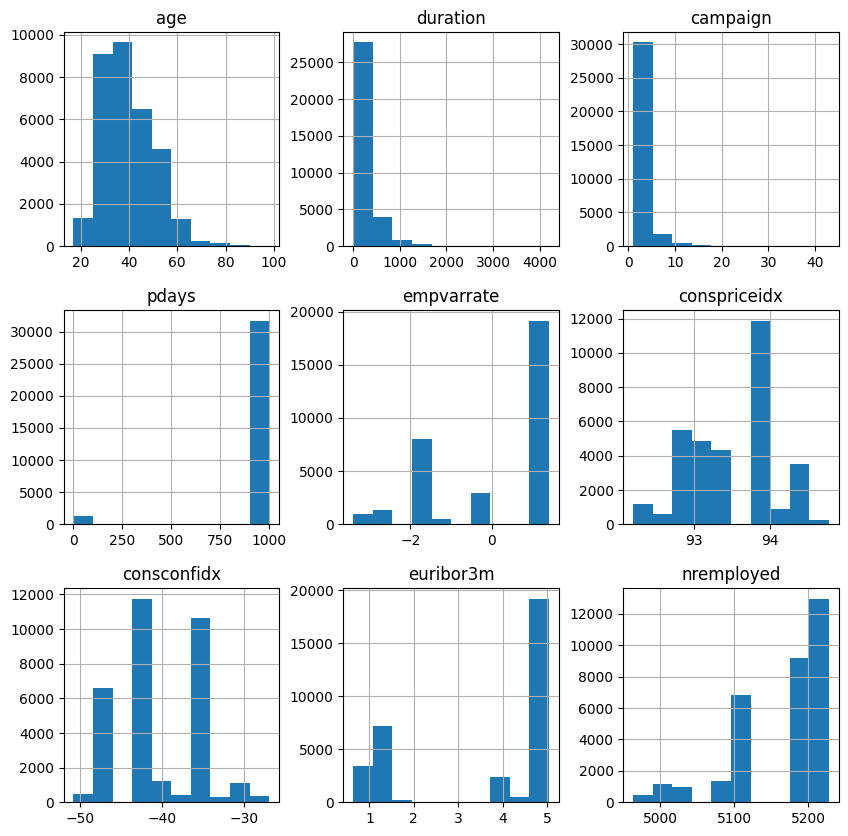

In [94]:
# Univariate analysis of categorical variables
df_train.select_dtypes(include=np.number).hist(figsize=(10,10))
plt.show()

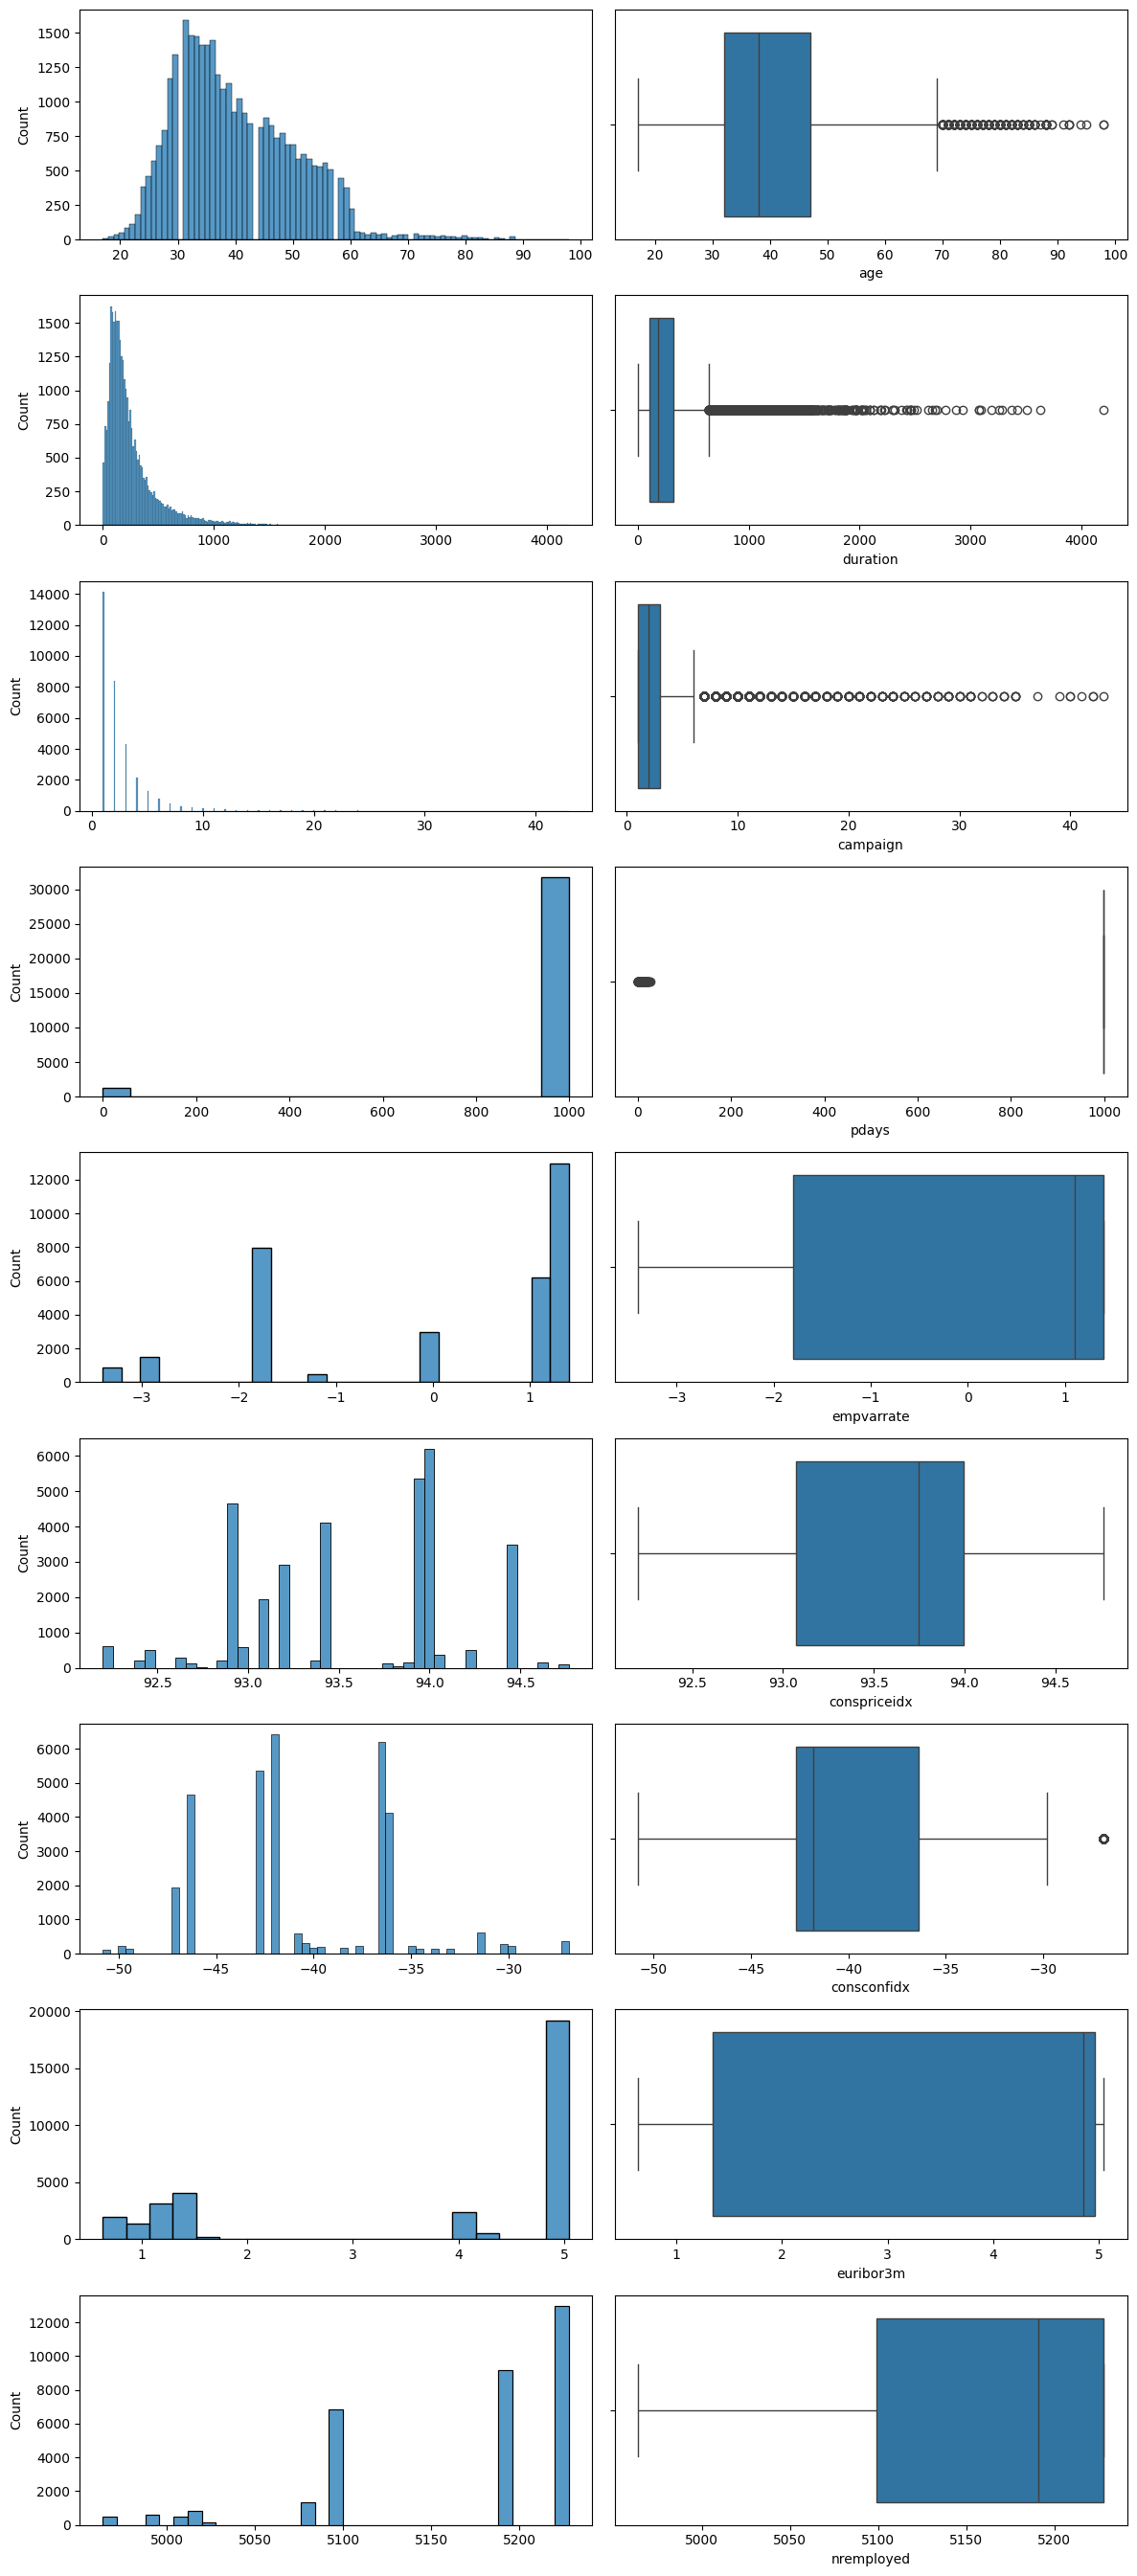

In [95]:
variables = ["age", "duration", "campaign", "pdays", "empvarrate", 
             "conspriceidx", "consconfidx", "euribor3m", "nremployed"]


fig, axes = plt.subplots(len(variables), 2, figsize=(12, len(variables) * 3))


for i, var in enumerate(variables):
    sns.histplot(ax=axes[i, 0], data=df_train, x=var).set(xlabel=None)
    sns.boxplot(ax=axes[i, 1], data=df_train, x=var)


fig.tight_layout()
plt.show()

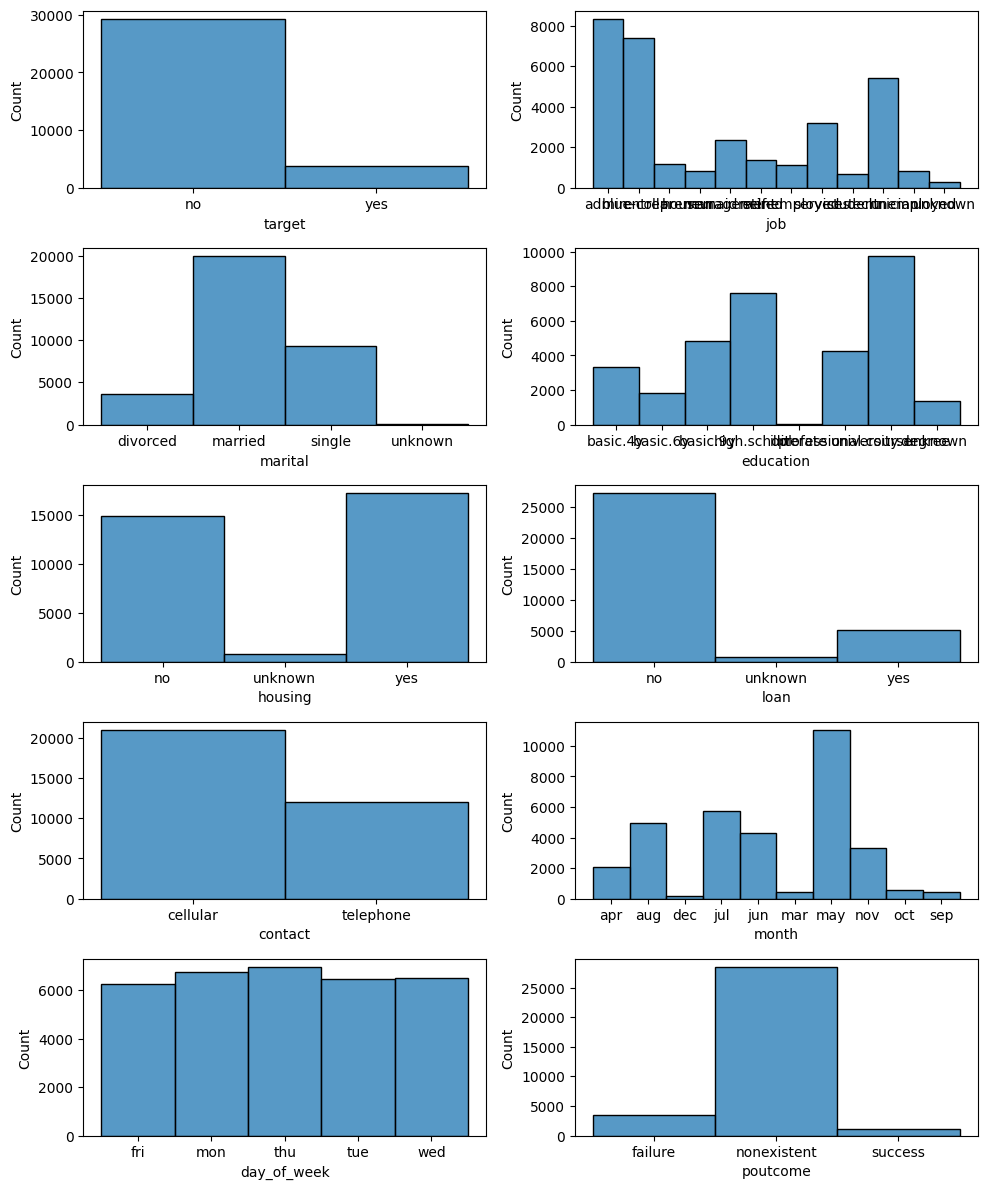

In [96]:
# Univariate analysis of categorical variables
fig, axis = plt.subplots(5, 2, figsize = (10, 12))
sns.histplot(ax = axis[0, 0], data = df_train, x = "target")
sns.histplot(ax = axis[0, 1], data = df_train, x = "job")
sns.histplot(ax = axis[1, 0], data = df_train, x = "marital")
sns.histplot(ax = axis[1, 1], data = df_train, x = "education")
sns.histplot(ax = axis[2, 0], data = df_train, x = "housing")
sns.histplot(ax = axis[2, 1], data = df_train, x = "loan")
sns.histplot(ax = axis[3, 0], data = df_train, x = "contact")
sns.histplot(ax = axis[3, 1], data = df_train, x = "month")
sns.histplot(ax = axis[4, 0], data = df_train, x = "day_of_week")
sns.histplot(ax = axis[4, 1], data = df_train, x = "poutcome")
fig.tight_layout()
plt.show()

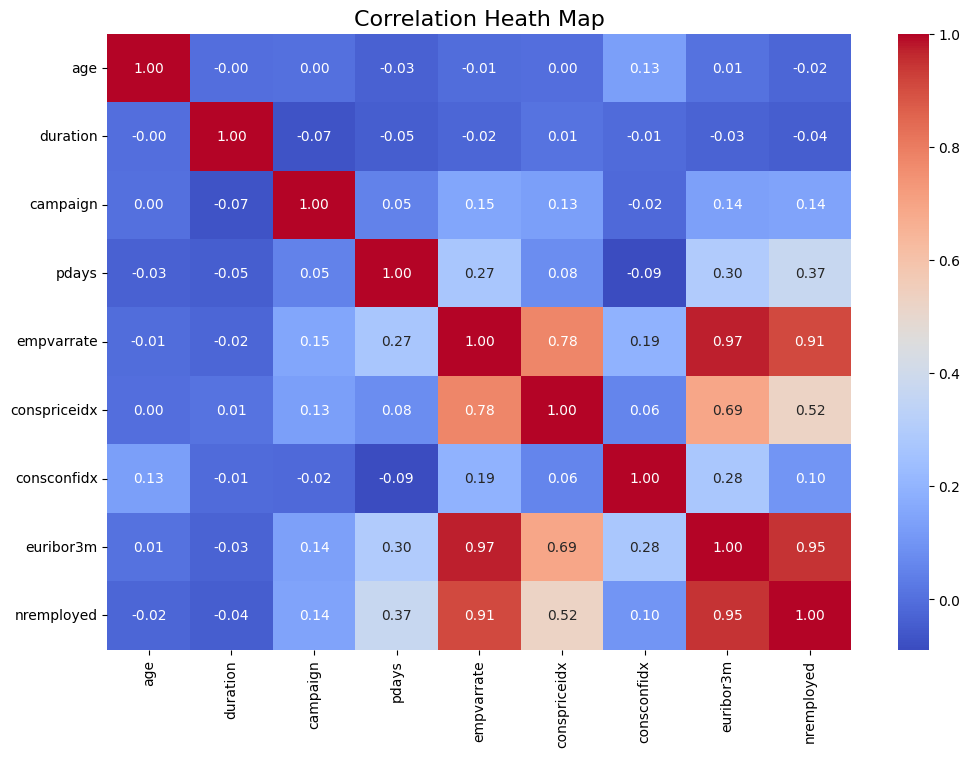

In [97]:
# Correlation matrix for numerical variables
# Multivariate analysis of numerical variables
numeric_df = df_train.select_dtypes(include=["number"])
correlation_matrix = numeric_df.corr()

# Heath map
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)


plt.title("Correlation Heath Map", fontsize=16)
plt.show()

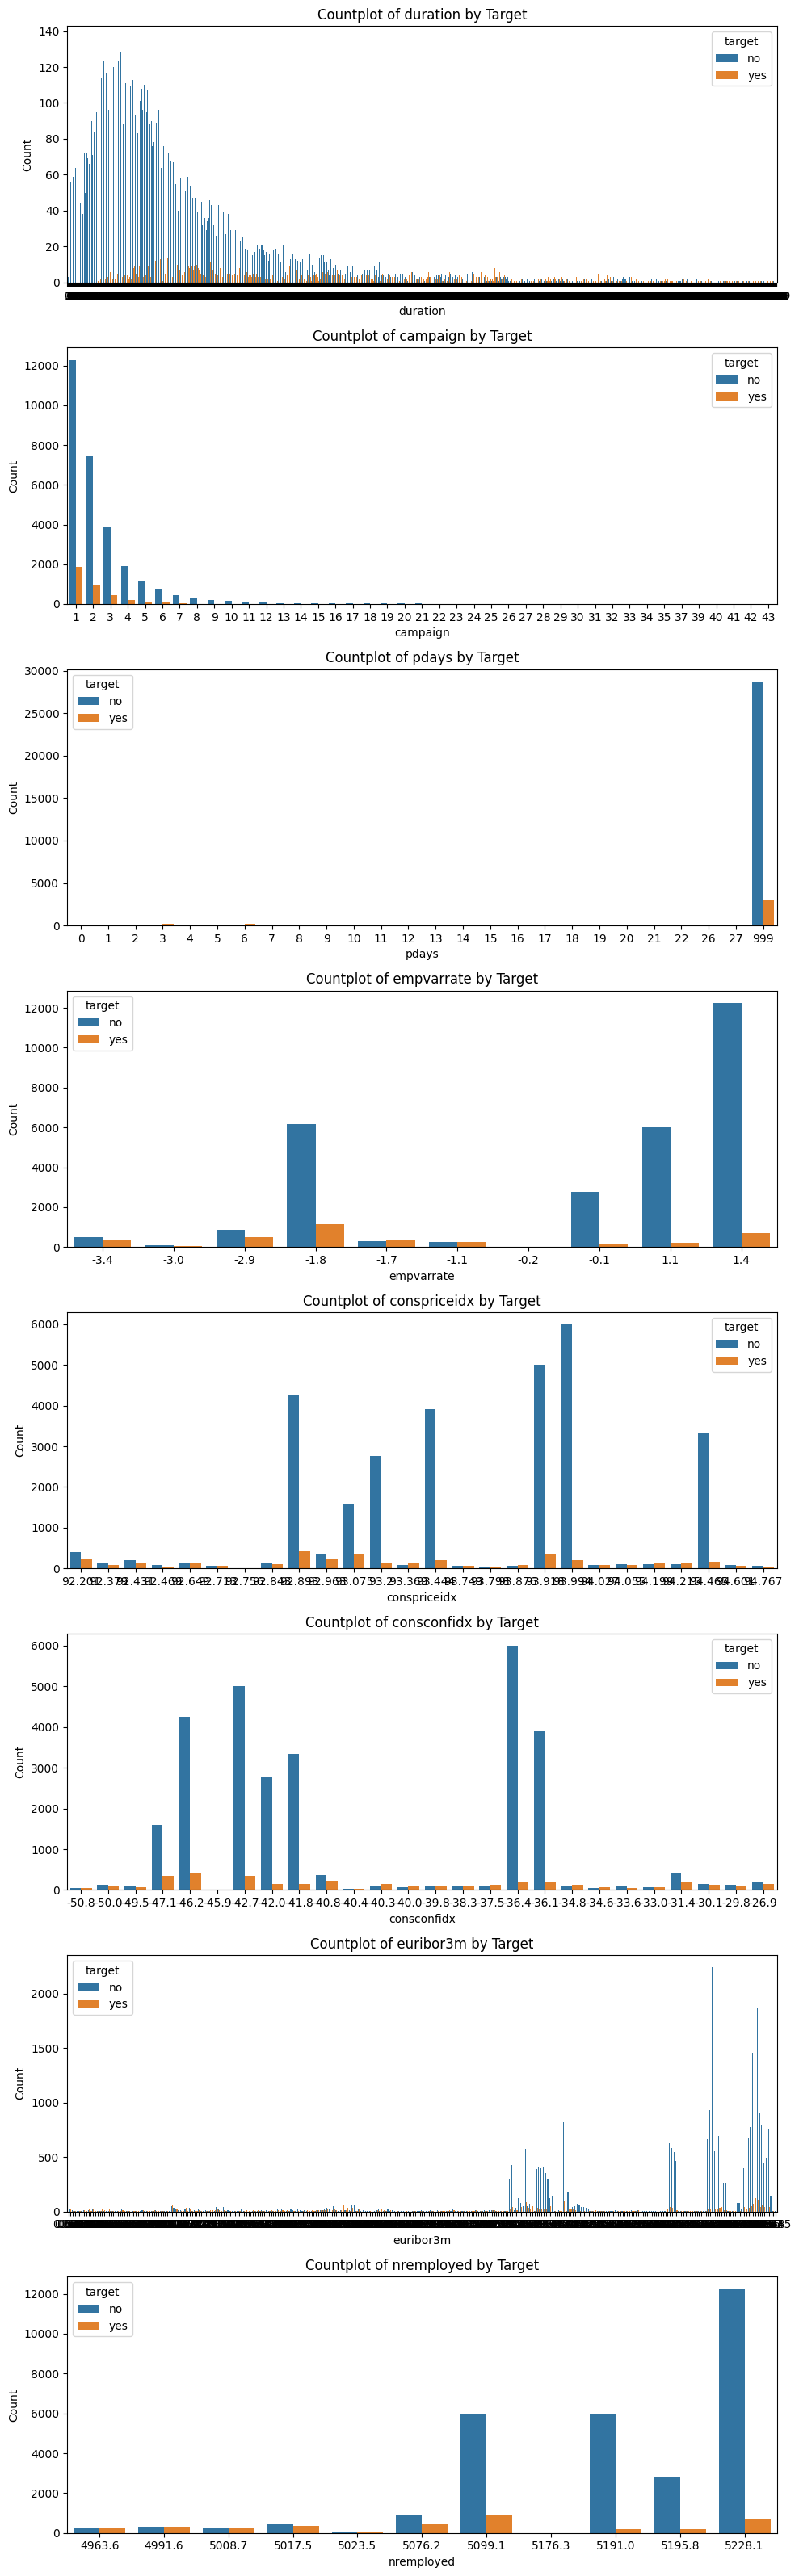

In [98]:
# Bivariate analysis of categorical variables
variables2 = ["duration", "campaign", "pdays", "empvarrate", 
             "conspriceidx", "consconfidx", "euribor3m", "nremployed"]

# Crear una cuadrícula de subgráficos
fig, axes = plt.subplots(len(variables2), 1, figsize=(10, len(variables2) * 4))

# Iterar sobre las variables y graficar
for i, var in enumerate(variables2):
    sns.countplot(data=df_train, x=var, hue="target", ax=axes[i])
    axes[i].set_title(f"Countplot of {var} by Target")
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel(var)

# Ajustar el diseño
plt.tight_layout()
plt.show()

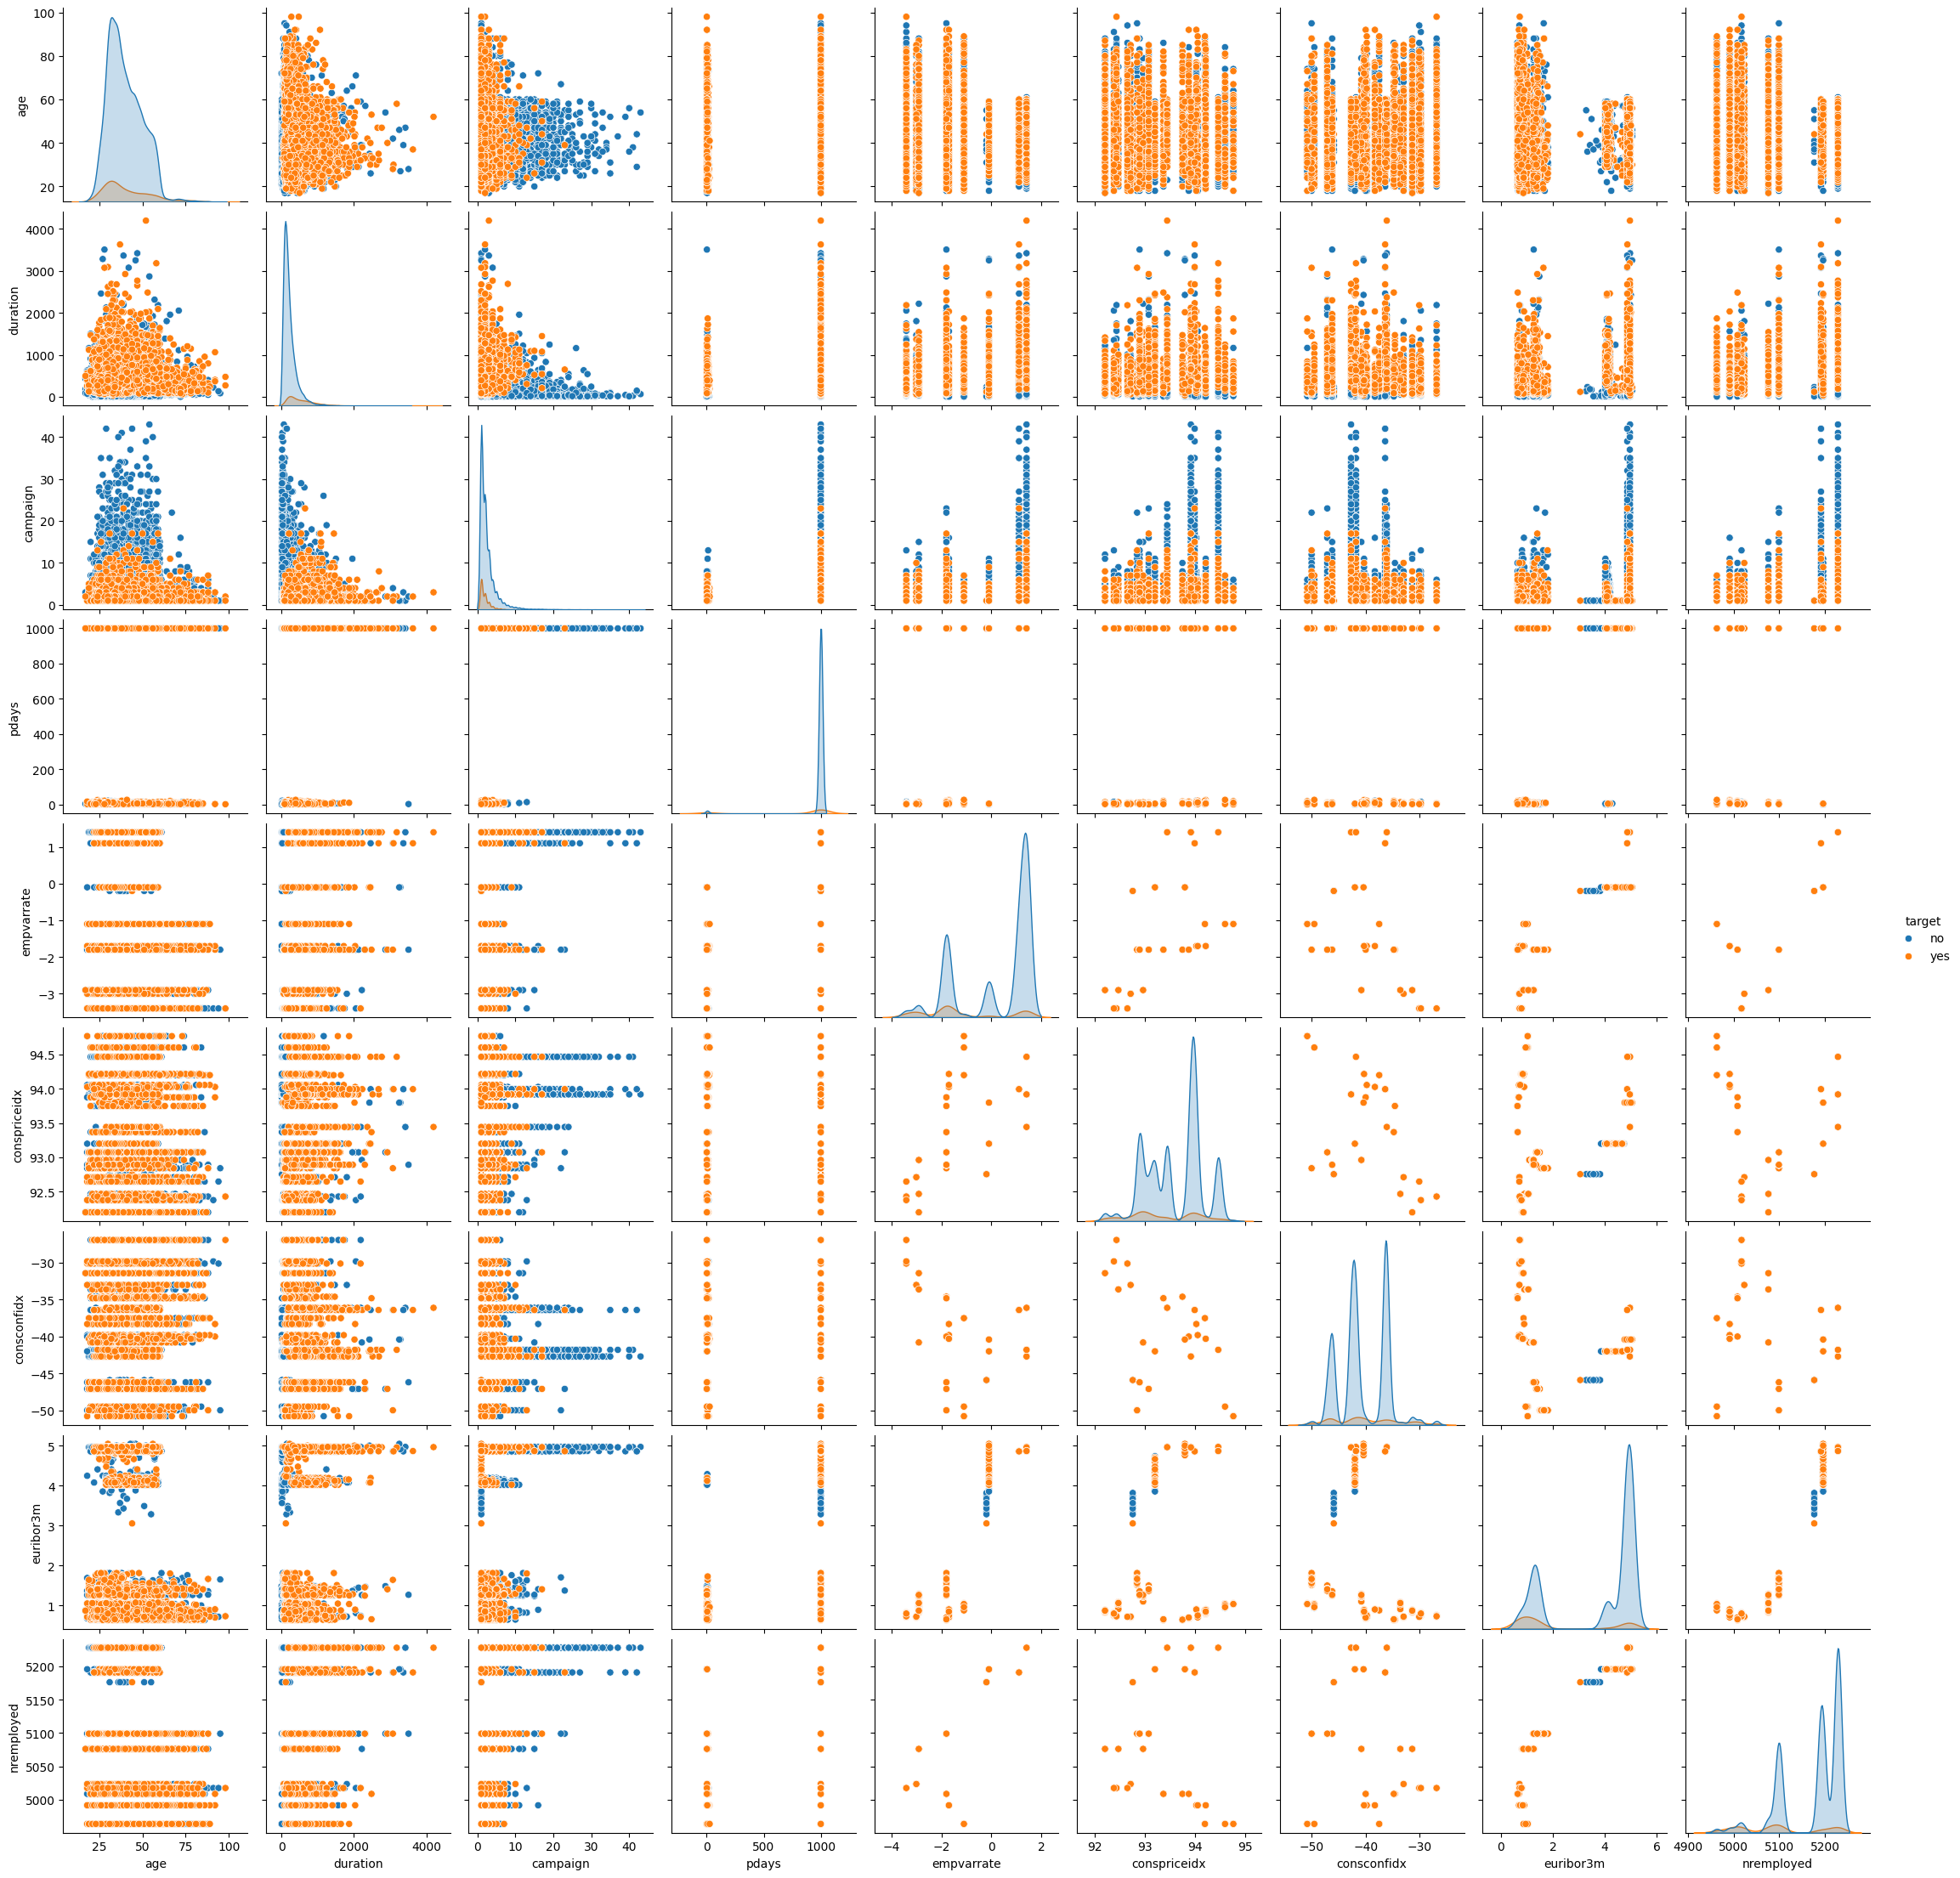

In [99]:
# Bivariate analysis numerical vs categorical
sns.pairplot(data = df_train, hue = "target")
plt.show()

In [100]:
# 4 Prepare data for training
# MixMax escaler
df_train["job_n"] = pd.factorize(df_train["job"])[0]
df_train["marital_n"] = pd.factorize(df_train["marital"])[0]
df_train["education_n"] = pd.factorize(df_train["education"])[0]
df_train["housing_n"] = pd.factorize(df_train["housing"])[0]
df_train["loan_n"] = pd.factorize(df_train["loan"])[0]
df_train["contact_n"] = pd.factorize(df_train["contact"])[0]
df_train["month_n"] = pd.factorize(df_train["month"])[0]
df_train["day_of_week_n"] = pd.factorize(df_train["day_of_week"])[0]
df_train["poutcome_n"] = pd.factorize(df_train["poutcome"])[0]
df_train["target_n"] = pd.factorize(df_train["target"])[0]
num_variables = ["job_n", "marital_n", "education_n", "housing_n", "loan_n", "contact_n", "month_n", "day_of_week_n", "poutcome_n",
                 "age", "duration", "campaign", "pdays", "empvarrate", "conspriceidx", "consconfidx", "euribor3m", "nremployed", "target_n"]

scaler = MinMaxScaler()
scal_features = scaler.fit_transform(df_train[num_variables])
total_data_scal = pd.DataFrame(scal_features, index = df_train.index, columns = num_variables)
total_data_scal.head()

,job_n,marital_n,education_n,housing_n,loan_n,contact_n,month_n,day_of_week_n,poutcome_n,age,duration,campaign,pdays,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,target_n
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.320988,0.017147,0.071429,0.006006,0.083333,0.199532,0.744770,0.018363,0.226465,0.0
19669,0.090909,0.333333,0.142857,0.5,0.0,1.0,0.111111,0.00,0.5,0.419753,0.085735,0.000000,1.000000,0.937500,0.698753,0.602510,0.957153,0.859735,0.0
19668,0.090909,0.000000,0.285714,0.0,0.0,0.0,0.222222,0.25,1.0,0.160494,0.100738,0.023810,1.000000,0.687500,0.389322,0.368201,0.767853,0.877883,0.0
19667,0.181818,0.000000,0.142857,0.0,0.0,1.0,0.111111,0.25,0.5,0.283951,0.019528,0.023810,1.000000,0.937500,0.698753,0.602510,0.958966,0.859735,0.0
19666,0.090909,0.000000,0.428571,0.0,0.5,0.0,0.333333,0.50,0.5,0.370370,0.070969,0.047619,1.000000,1.000000,0.669135,0.338912,0.981183,1.000000,0.0


In [101]:
# Feature selection
X = total_data_scal.drop("target_n", axis = 1)
y = total_data_scal["target_n"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

selection_model = SelectKBest(chi2, k = 5)
selection_model.fit(X_train, y_train)
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

X_train_sel.head()

,contact_n,duration,empvarrate,euribor3m,nremployed
0,0.0,0.059538,1.000000,0.981410,1.000000
1,0.0,0.005239,0.333333,0.174790,0.512287
2,0.0,0.050488,1.000000,0.981410,1.000000
3,1.0,0.043106,0.937500,0.957379,0.859735
4,0.0,0.001667,0.333333,0.143278,0.512287


In [102]:
X_train_sel["target_n"] = list(y_train)
X_test_sel["target_n"] = list(y_test)
X_train_sel.to_csv("data/processed/clean_train.csv", index = False)
X_test_sel.to_csv("data/processed/clean_test.csv", index = False)

In [103]:
train_data = pd.read_csv("data/processed/clean_train.csv")
test_data = pd.read_csv("data/processed/clean_test.csv")

train_data.head()

,contact_n,duration,empvarrate,euribor3m,nremployed,target_n
0,0.0,0.059538,1.000000,0.981410,1.000000,0.0
1,0.0,0.005239,0.333333,0.174790,0.512287,0.0
2,0.0,0.050488,1.000000,0.981410,1.000000,0.0
3,1.0,0.043106,0.937500,0.957379,0.859735,0.0
4,0.0,0.001667,0.333333,0.143278,0.512287,0.0


In [104]:
X_train = train_data.drop(["target_n"], axis = 1)
y_train = train_data["target_n"]
X_test = test_data.drop(["target_n"], axis = 1)
y_test = test_data["target_n"]

In [105]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [106]:
y_pred = model.predict(X_test)
y_pred

array([0., 0., 1., ..., 0., 0., 0.])

In [107]:
accuracy_score(y_test, y_pred)

0.9028536733454766

In [108]:
# Model Optimization
# We define the parameters that we want to adjust by hand
hyperparams = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "penalty": ["l1", "l2", "elasticnet", None],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

# We initialize the grid
grid = GridSearchCV(model, hyperparams, scoring = "accuracy", cv = 5)
grid

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [109]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

grid.fit(X_train, y_train)

print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}


In [110]:
model_grid = LogisticRegression(penalty = "l1", C = 10, solver = "liblinear")
model_grid.fit(X_train, y_train)
y_pred2 = model_grid.predict(X_test)

grid_accuracy = accuracy_score(y_test, y_pred2)
grid_accuracy

0.9052823315118397

In [111]:
y_pred3 = model.predict(X_test)
y_pred3

array([0., 0., 1., ..., 0., 0., 0.])

In [112]:
accuracy_score(y_test, y_pred3)

0.9028536733454766